# CTMS Model Training with Optimal Configuration

This notebook trains CTMS models using the optimal configurations found by distance-based classification search.

**Prerequisites**: 
1. Run the distance-based classification search
2. Ensure `best_without_config.json` and `best_with_config.json` exist

**Outputs**:
- `trained_model_without_personalization.pt` - Model with fixed optimal weights
- `trained_model_with_personalization.pt` - Model for personalized weight selection

**Author**: AD-Moments Team  
**Date**: 2025-01-24

## 1. Setup and Imports

In [58]:
import sys
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict
from datetime import datetime
import copy

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Using CPU")

# Set random seeds (will be overridden by config seed)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using GPU: NVIDIA GeForce RTX 4090
GPU Memory: 25.36 GB


In [59]:
# Import CTMS modules
from ctms_model_gpu import CTMSModelGPU

print("✓ CTMS modules imported successfully")

✓ CTMS modules imported successfully


## 2. Load Optimal Configurations

In [60]:
print("="*80)
print("LOADING OPTIMAL CONFIGURATIONS")
print("="*80)

# Load best configurations
with open('best_without_config.json', 'r') as f:
    best_without = json.load(f)

with open('best_with_config.json', 'r') as f:
    best_with = json.load(f)

print("\n✓ Loaded configuration files")
print(f"\n{'='*80}")
print("BEST WITHOUT PERSONALIZATION (Fixed Global Weights)")
print(f"{'='*80}")
print(f"  Weights name: {best_without['decision']['weights_name']}")
print(f"  Weights: {best_without['decision']['weights']}")
print(f"  Train ratio: {best_without['config']['cn_train_ratio']}")
print(f"  F1 Score: {best_without['score']:.4f}")
print(f"  Accuracy: {best_without['metrics']['final']['accuracy']:.4f}")
print(f"  Balanced Acc: {best_without['metrics']['final']['balanced_accuracy']:.4f}")
print(f"  MCC: {best_without['metrics']['final']['mcc']:.4f}")

print(f"\n{'='*80}")
print("BEST WITH PERSONALIZATION (Adaptive Per-Person Weights)")
print(f"{'='*80}")
print(f"  Method: {best_with['config']['selection']}")
print(f"  Alpha (FPR control): {best_with['config']['alpha']}")
print(f"  Train ratio: {best_with['config']['cn_train_ratio']}")
print(f"  F1 Score: {best_with['score']:.4f}")
print(f"  Accuracy: {best_with['metrics']['final']['accuracy']:.4f}")
print(f"  Balanced Acc: {best_with['metrics']['final']['balanced_accuracy']:.4f}")
print(f"  MCC: {best_with['metrics']['final']['mcc']:.4f}")
print(f"\n  Most used weights:")
top_weights = best_with['metrics']['summary']['weights_top_counts']
for weight_name, count in sorted(top_weights.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"    {weight_name}: {count} subjects")

print(f"\n{'='*80}\n")

LOADING OPTIMAL CONFIGURATIONS

✓ Loaded configuration files

BEST WITHOUT PERSONALIZATION (Fixed Global Weights)
  Weights name: Movement++
  Weights: [0.1, 0.1, 0.7, 0.1]
  Train ratio: 0.5
  F1 Score: 0.8542
  Accuracy: 0.7455
  Balanced Acc: 0.4881
  MCC: -0.0757

BEST WITH PERSONALIZATION (Adaptive Per-Person Weights)
  Method: fixed_fpr
  Alpha (FPR control): 0.975
  Train ratio: 0.5
  F1 Score: 0.3462
  Accuracy: 0.3818
  Balanced Acc: 0.5687
  MCC: 0.1513

  Most used weights:
    Social++: 42 subjects
    Movement++: 13 subjects




## 3. Load Raw Data

In [61]:
# Data paths - UPDATE THESE IF NEEDED
SEQUENCE_FILE = '../sample_data/sequences.jsonl'
LABEL_FILE = '../sample_data/subjects.json'

def load_data(sequence_file, label_file):
    """Load sequences and labels"""
    # Load sequences
    sequences = defaultdict(list)
    with open(sequence_file, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            sequences[data['anon_id']].append(data)
    
    # Load labels
    with open(label_file, 'r') as f:
        label_data = json.load(f)
        if isinstance(label_data, list):
            labels = {item['anon_id']: item for item in label_data}
        else:
            labels = label_data
    
    return sequences, labels

print("Loading raw data...")
sequences, labels = load_data(SEQUENCE_FILE, LABEL_FILE)

print(f"\n✓ Data loaded")
print(f"  Total participants: {len(sequences)}")
print(f"  Total sequences: {sum(len(s) for s in sequences.values())}")

Loading raw data...

✓ Data loaded
  Total participants: 68
  Total sequences: 128


## 4. Data Preparation Functions

In [62]:
def create_datasets_from_ids(sequences, train_ids, test_ids):
    """Create train and test datasets from participant IDs"""
    train_data = []
    test_data = []
    
    # Training data
    for aid in train_ids:
        if aid not in sequences:
            continue
        for seq_data in sequences[aid]:
            train_data.append({
                'sequence': seq_data['sequence'],
                'label': labels[aid].get('label_binary', 0 if labels[aid]['label'] == 'CN' else 1),
                'anon_id': aid
            })
    
    # Test data
    for aid in test_ids:
        if aid not in sequences:
            continue
        for seq_data in sequences[aid]:
            test_data.append({
                'sequence': seq_data['sequence'],
                'label': labels[aid].get('label_binary', 0 if labels[aid]['label'] == 'CN' else 1),
                'anon_id': aid
            })
    
    return train_data, test_data


def preprocess_batch(batch_data, device, max_len=500):
    """Preprocess a batch of sequences"""
    activity_ids = []
    timestamps = []
    labels_batch = []
    
    for item in batch_data:
        seq = item['sequence'][:max_len]
        
        # Extract activity IDs and timestamps
        acts = [s['action_id'] for s in seq]
        times = [s['ts'] for s in seq]
        
        # Normalize timestamps to [0, 1]
        if len(times) > 1:
            min_t, max_t = min(times), max(times)
            if max_t > min_t:
                times = [(t - min_t) / (max_t - min_t) for t in times]
            else:
                times = [0.0] * len(times)
        
        activity_ids.append(torch.LongTensor(acts))
        timestamps.append(torch.FloatTensor(times))
        labels_batch.append(item['label'])
    
    # Pad sequences
    activity_ids = nn.utils.rnn.pad_sequence(activity_ids, batch_first=True, padding_value=0)
    timestamps = nn.utils.rnn.pad_sequence(timestamps, batch_first=True, padding_value=0.0)
    labels_batch = torch.FloatTensor(labels_batch)
    
    return {
        'activity_ids': activity_ids.to(device),
        'timestamps': timestamps.to(device),
        'labels': labels_batch.to(device)
    }

print("✓ Data preparation functions defined")

✓ Data preparation functions defined


## 5. Training Function

In [63]:
def train_model(model, train_data, val_data, epochs, batch_size, lr, device, desc="Training"):
    """Train the model"""
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.BCELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=False
    )
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    max_patience = 10
    
    history = {'train_loss': [], 'val_loss': []}
    
    print(f"\n{desc}...")
    pbar = tqdm(range(epochs), desc=desc)
    
    for epoch in pbar:
        # Training
        model.train()
        np.random.shuffle(train_data)
        train_loss = 0
        n_batches = 0
        
        for i in range(0, len(train_data), batch_size):
            batch = preprocess_batch(train_data[i:i+batch_size], device)
            
            optimizer.zero_grad()
            outputs = model(batch['activity_ids'], batch['timestamps'])
            loss = criterion(outputs['output'], batch['labels'])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
            n_batches += 1
        
        train_loss /= n_batches
        history['train_loss'].append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        n_val_batches = 0
        
        with torch.no_grad():
            for i in range(0, len(val_data), batch_size):
                batch = preprocess_batch(val_data[i:i+batch_size], device)
                outputs = model(batch['activity_ids'], batch['timestamps'])
                loss = criterion(outputs['output'], batch['labels'])
                val_loss += loss.item()
                n_val_batches += 1
        
        val_loss /= n_val_batches
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)
        
        # Update progress bar
        pbar.set_postfix({
            'train_loss': f'{train_loss:.4f}',
            'val_loss': f'{val_loss:.4f}',
            'best': f'{best_val_loss:.4f}'
        })
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= max_patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, best_val_loss, history

print("✓ Training function defined")

✓ Training function defined


## 6. Train Model WITHOUT Personalization (Fixed Global Weights)

In [64]:
print("="*80)
print("TRAINING MODEL WITHOUT PERSONALIZATION")
print("="*80)

# Extract configuration
config_wo = best_without['config']
SEED = config_wo['seed']
train_cn_ids = best_without['data_split']['train_cn_ids']
test_subjects = best_without['data_split']['test']
test_ids = [s['anon_id'] for s in test_subjects]

# Set seed
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"\nConfiguration:")
print(f"  Seed: {SEED}")
print(f"  Train CN: {len(train_cn_ids)} subjects")
print(f"  Test: {len(test_ids)} subjects")
print(f"  Weights: {best_without['decision']['weights']}")

# Create datasets
train_data, test_data = create_datasets_from_ids(sequences, train_cn_ids, test_ids)

# Split train into train/val
np.random.seed(SEED + 1)
np.random.shuffle(train_data)
val_split = int(0.15 * len(train_data))
val_data = train_data[:val_split]
train_data = train_data[val_split:]

print(f"\nDataset sizes:")
print(f"  Train: {len(train_data)} sequences")
print(f"  Val: {len(val_data)} sequences")
print(f"  Test: {len(test_data)} sequences")

# Training configuration
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 2e-4

print(f"\nTraining parameters:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")

# Initialize model
model_wo = CTMSModelGPU(
    d_model=128,
    num_activities=21,
    num_task_templates=20,
    use_fast_similarity=True
).to(device)

# Train model
trained_model_wo, val_loss_wo, history_wo = train_model(
    model_wo, train_data, val_data,
    EPOCHS, BATCH_SIZE, LEARNING_RATE, device,
    desc="Training WITHOUT Personalization"
)

print(f"\n✓ Training complete!")
print(f"  Best val loss: {val_loss_wo:.4f}")

TRAINING MODEL WITHOUT PERSONALIZATION

Configuration:
  Seed: 123
  Train CN: 13 subjects
  Test: 55 subjects
  Weights: [0.1, 0.1, 0.7, 0.1]

Dataset sizes:
  Train: 20 sequences
  Val: 3 sequences
  Test: 105 sequences

Training parameters:
  Epochs: 50
  Batch size: 64
  Learning rate: 0.0002

Training WITHOUT Personalization...


/home/heming/anaconda3/envs/moments/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training WITHOUT Personalization:   0%|          | 0/50 [00:00<?, ?it/s]


✓ Training complete!
  Best val loss: 0.0000


In [65]:
# Compute baseline statistics from train CN
print("\nComputing baseline statistics...")

train_cn_data = [item for item in train_data + val_data if item['label'] == 0]

baseline_encodings_wo = {
    'circadian': [],
    'task': [],
    'movement': [],
    'social': []
}

trained_model_wo.eval()
with torch.no_grad():
    for i in range(0, len(train_cn_data), 64):
        batch = train_cn_data[i:i+64]
        batch_proc = preprocess_batch(batch, device)
        
        outputs = trained_model_wo(
            batch_proc['activity_ids'],
            batch_proc['timestamps'],
            return_encodings_only=True
        )
        
        baseline_encodings_wo['circadian'].append(torch.norm(outputs['h_c'], dim=1).cpu().numpy())
        baseline_encodings_wo['task'].append(torch.norm(outputs['h_t'], dim=1).cpu().numpy())
        baseline_encodings_wo['movement'].append(torch.norm(outputs['h_m'], dim=1).cpu().numpy())
        baseline_encodings_wo['social'].append(torch.norm(outputs['h_s'], dim=1).cpu().numpy())

baseline_stats_wo = {}
for dim in ['circadian', 'task', 'movement', 'social']:
    norms = np.concatenate(baseline_encodings_wo[dim])
    baseline_stats_wo[dim] = {
        'mean': float(np.mean(norms)),
        'std': float(np.std(norms)) if np.std(norms) > 1e-6 else 1.0
    }

print("\nBaseline statistics:")
for dim in ['circadian', 'task', 'movement', 'social']:
    print(f"  {dim.capitalize():12s}: mean={baseline_stats_wo[dim]['mean']:.3f}, std={baseline_stats_wo[dim]['std']:.3f}")

print("\n✓ Baseline computed")


Computing baseline statistics...

Baseline statistics:
  Circadian   : mean=9.766, std=0.057
  Task        : mean=31.398, std=0.685
  Movement    : mean=146.234, std=0.616
  Social      : mean=73.094, std=143.864

✓ Baseline computed


In [66]:
# Save model
print("\nSaving model WITHOUT personalization...")

checkpoint_wo = {
    'model_state_dict': trained_model_wo.state_dict(),
    'config': {
        'type': 'without_personalization',
        'cn_train_ratio': config_wo['cn_train_ratio'],
        'use_ci_in_train': config_wo['use_ci_in_train'],
        'weights': best_without['decision']['weights'],
        'weights_name': best_without['decision']['weights_name'],
        'threshold': best_without['decision']['threshold'],
        'center': best_without['decision']['center'],
        'std': best_without['decision']['std'],
        'd_model': 128,
        'num_activities': 21,
        'num_task_templates': 20,
        'seed': SEED
    },
    'data_split': {
        'train_cn_ids': train_cn_ids,
        'test_ids': test_ids
    },
    'baseline_stats': baseline_stats_wo,
    'training': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'val_loss': val_loss_wo,
        'history': history_wo
    },
    'distance_metrics': best_without['metrics']
}

torch.save(checkpoint_wo, 'trained_model_without_personalization.pt')

print("✓ Saved: trained_model_without_personalization.pt")


Saving model WITHOUT personalization...
✓ Saved: trained_model_without_personalization.pt


## 7. Train Model WITH Personalization (Adaptive Per-Person Weights)

In [67]:
print("\n" + "="*80)
print("TRAINING MODEL WITH PERSONALIZATION")
print("="*80)

# Extract configuration
config_w = best_with['config']
SEED_W = config_w['seed']
train_cn_ids_w = best_with['data_split']['train_cn_ids']
test_subjects_w = best_with['data_split']['test']
test_ids_w = [s['anon_id'] for s in test_subjects_w]

# Set seed
torch.manual_seed(SEED_W)
np.random.seed(SEED_W)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_W)

print(f"\nConfiguration:")
print(f"  Seed: {SEED_W}")
print(f"  Train CN: {len(train_cn_ids_w)} subjects")
print(f"  Test: {len(test_ids_w)} subjects")
print(f"  Method: {config_w['selection']}")
print(f"  Alpha: {config_w['alpha']}")
print(f"  Weight library size: {len(best_with['weights_library'])}")

# Create datasets
train_data_w, test_data_w = create_datasets_from_ids(sequences, train_cn_ids_w, test_ids_w)

# Split train into train/val
np.random.seed(SEED_W + 1)
np.random.shuffle(train_data_w)
val_split_w = int(0.15 * len(train_data_w))
val_data_w = train_data_w[:val_split_w]
train_data_w = train_data_w[val_split_w:]

print(f"\nDataset sizes:")
print(f"  Train: {len(train_data_w)} sequences")
print(f"  Val: {len(val_data_w)} sequences")
print(f"  Test: {len(test_data_w)} sequences")

# Initialize model
model_w = CTMSModelGPU(
    d_model=128,
    num_activities=21,
    num_task_templates=20,
    use_fast_similarity=True
).to(device)

# Train model
trained_model_w, val_loss_w, history_w = train_model(
    model_w, train_data_w, val_data_w,
    EPOCHS, BATCH_SIZE, LEARNING_RATE, device,
    desc="Training WITH Personalization"
)

print(f"\n✓ Training complete!")
print(f"  Best val loss: {val_loss_w:.4f}")


TRAINING MODEL WITH PERSONALIZATION

Configuration:
  Seed: 123
  Train CN: 13 subjects
  Test: 55 subjects
  Method: fixed_fpr
  Alpha: 0.975
  Weight library size: 14

Dataset sizes:
  Train: 20 sequences
  Val: 3 sequences
  Test: 105 sequences

Training WITH Personalization...


Training WITH Personalization:   0%|          | 0/50 [00:00<?, ?it/s]


✓ Training complete!
  Best val loss: 0.0000


In [68]:
# Compute baseline statistics
print("\nComputing baseline statistics...")

train_cn_data_w = [item for item in train_data_w + val_data_w if item['label'] == 0]

baseline_encodings_w = {
    'circadian': [],
    'task': [],
    'movement': [],
    'social': []
}

trained_model_w.eval()
with torch.no_grad():
    for i in range(0, len(train_cn_data_w), 64):
        batch = train_cn_data_w[i:i+64]
        batch_proc = preprocess_batch(batch, device)
        
        outputs = trained_model_w(
            batch_proc['activity_ids'],
            batch_proc['timestamps'],
            return_encodings_only=True
        )
        
        baseline_encodings_w['circadian'].append(torch.norm(outputs['h_c'], dim=1).cpu().numpy())
        baseline_encodings_w['task'].append(torch.norm(outputs['h_t'], dim=1).cpu().numpy())
        baseline_encodings_w['movement'].append(torch.norm(outputs['h_m'], dim=1).cpu().numpy())
        baseline_encodings_w['social'].append(torch.norm(outputs['h_s'], dim=1).cpu().numpy())

baseline_stats_w = {}
for dim in ['circadian', 'task', 'movement', 'social']:
    norms = np.concatenate(baseline_encodings_w[dim])
    baseline_stats_w[dim] = {
        'mean': float(np.mean(norms)),
        'std': float(np.std(norms)) if np.std(norms) > 1e-6 else 1.0
    }

print("\nBaseline statistics:")
for dim in ['circadian', 'task', 'movement', 'social']:
    print(f"  {dim.capitalize():12s}: mean={baseline_stats_w[dim]['mean']:.3f}, std={baseline_stats_w[dim]['std']:.3f}")

print("\n✓ Baseline computed")


Computing baseline statistics...

Baseline statistics:
  Circadian   : mean=9.766, std=0.057
  Task        : mean=31.398, std=0.685
  Movement    : mean=146.234, std=0.616
  Social      : mean=73.093, std=143.865

✓ Baseline computed


In [69]:
# Save model
print("\nSaving model WITH personalization...")

checkpoint_w = {
    'model_state_dict': trained_model_w.state_dict(),
    'config': {
        'type': 'with_personalization',
        'selection': config_w['selection'],
        'alpha': config_w['alpha'],
        'cn_train_ratio': config_w['cn_train_ratio'],
        'use_ci_in_train': config_w['use_ci_in_train'],
        'd_model': 128,
        'num_activities': 21,
        'num_task_templates': 20,
        'seed': SEED_W,
        'global_fallback_used': config_w['global_fallback_used']
    },
    'data_split': {
        'train_cn_ids': train_cn_ids_w,
        'test_ids': test_ids_w
    },
    'baseline_stats': baseline_stats_w,
    'weights_library': best_with['weights_library'],
    'thresholds_per_weight': best_with['thresholds_per_weight'],
    'per_subject_decisions': best_with['per_subject'],
    'training': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'val_loss': val_loss_w,
        'history': history_w
    },
    'distance_metrics': best_with['metrics']
}

torch.save(checkpoint_w, 'trained_model_with_personalization.pt')

print("✓ Saved: trained_model_with_personalization.pt")


Saving model WITH personalization...
✓ Saved: trained_model_with_personalization.pt


## 8. Training History Visualization

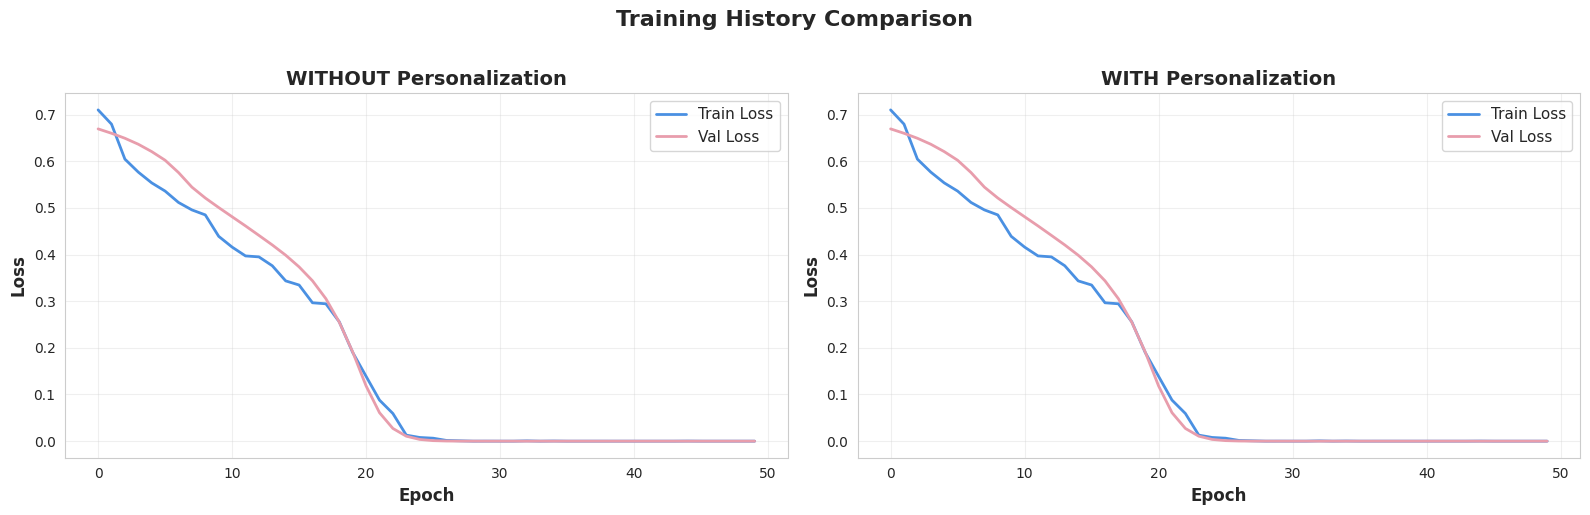

✓ Saved training history: training_history_comparison.png


In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# WITHOUT personalization
ax = axes[0]
ax.plot(history_wo['train_loss'], label='Train Loss', linewidth=2, color='#4A90E2')
ax.plot(history_wo['val_loss'], label='Val Loss', linewidth=2, color='#E89DAC')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('WITHOUT Personalization', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# WITH personalization
ax = axes[1]
ax.plot(history_w['train_loss'], label='Train Loss', linewidth=2, color='#4A90E2')
ax.plot(history_w['val_loss'], label='Val Loss', linewidth=2, color='#E89DAC')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('WITH Personalization', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.suptitle('Training History Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
#plt.savefig('training_history_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved training history: training_history_comparison.png")

## 9. Final Summary

In [71]:
print("="*80)
print("TRAINING SUMMARY")
print("="*80)

print("\n📊 WITHOUT PERSONALIZATION (Fixed Global Weights)")
print(f"  Weights: {best_without['decision']['weights_name']}")
print(f"  Values: {best_without['decision']['weights']}")
print(f"  Training val loss: {val_loss_wo:.4f}")
print(f"  Distance-based F1: {best_without['score']:.4f}")
print(f"  Distance-based Acc: {best_without['metrics']['final']['accuracy']:.4f}")
print(f"  Distance-based MCC: {best_without['metrics']['final']['mcc']:.4f}")
print(f"  Model saved: trained_model_without_personalization.pt")

print("\n📊 WITH PERSONALIZATION (Adaptive Per-Person Weights)")
print(f"  Method: {config_w['selection']} (alpha={config_w['alpha']})")
print(f"  Weight library size: {len(best_with['weights_library'])}")
print(f"  Training val loss: {val_loss_w:.4f}")
print(f"  Distance-based F1: {best_with['score']:.4f}")
print(f"  Distance-based Acc: {best_with['metrics']['final']['accuracy']:.4f}")
print(f"  Distance-based MCC: {best_with['metrics']['final']['mcc']:.4f}")
print(f"  Model saved: trained_model_with_personalization.pt")

print("\n💾 Saved Files:")
print("  1. trained_model_without_personalization.pt")
print("  2. trained_model_with_personalization.pt")
print("  3. training_history_comparison.png")

print("\n📈 Performance Comparison (Distance-based Classification):")
comparison_df = pd.DataFrame([
    {
        'Mode': 'WITHOUT',
        'F1': f"{best_without['metrics']['final']['f1']:.3f}",
        'Accuracy': f"{best_without['metrics']['final']['accuracy']:.3f}",
        'Precision': f"{best_without['metrics']['final']['precision']:.3f}",
        'Recall': f"{best_without['metrics']['final']['recall_sensitivity']:.3f}",
        'Specificity': f"{best_without['metrics']['final']['specificity']:.3f}",
        'MCC': f"{best_without['metrics']['final']['mcc']:.3f}"
    },
    {
        'Mode': 'WITH',
        'F1': f"{best_with['metrics']['final']['f1']:.3f}",
        'Accuracy': f"{best_with['metrics']['final']['accuracy']:.3f}",
        'Precision': f"{best_with['metrics']['final']['precision']:.3f}",
        'Recall': f"{best_with['metrics']['final']['recall_sensitivity']:.3f}",
        'Specificity': f"{best_with['metrics']['final']['specificity']:.3f}",
        'MCC': f"{best_with['metrics']['final']['mcc']:.3f}"
    }
])
print(comparison_df.to_string(index=False))

print("\n✅ Both models trained successfully!")
print("   Use these models for visualization and analysis.")
print("\n" + "="*80)

TRAINING SUMMARY

📊 WITHOUT PERSONALIZATION (Fixed Global Weights)
  Weights: Movement++
  Values: [0.1, 0.1, 0.7, 0.1]
  Training val loss: 0.0000
  Distance-based F1: 0.8542
  Distance-based Acc: 0.7455
  Distance-based MCC: -0.0757
  Model saved: trained_model_without_personalization.pt

📊 WITH PERSONALIZATION (Adaptive Per-Person Weights)
  Method: fixed_fpr (alpha=0.975)
  Weight library size: 14
  Training val loss: 0.0000
  Distance-based F1: 0.3462
  Distance-based Acc: 0.3818
  Distance-based MCC: 0.1513
  Model saved: trained_model_with_personalization.pt

💾 Saved Files:
  1. trained_model_without_personalization.pt
  2. trained_model_with_personalization.pt
  3. training_history_comparison.png

📈 Performance Comparison (Distance-based Classification):
   Mode    F1 Accuracy Precision Recall Specificity    MCC
WITHOUT 0.854    0.745     0.759  0.976       0.000 -0.076
   WITH 0.346    0.382     0.900  0.214       0.923  0.151

✅ Both models trained successfully!
   Use these 

GENERATING VIOLIN PLOTS

Available models:
  1. trained_model_without_personalization.pt
  2. trained_model_with_personalization.pt

📂 Loading model: trained_model_without_personalization.pt

✓ Checkpoint loaded
  Type: without_personalization
  Weights: Movement++
  Train ratio: 0.5
  Val loss: 0.0000
✓ Model loaded and set to eval mode

Data split:
  Train CN: 13 subjects
  Test: 55 subjects

📄 Extracting encodings from TEST subjects...
  ✓ 46 (CN): 2 months
  ✓ 53 (CN): 2 months
  ✓ 41 (CN): 2 months
  ✓ 47 (CN): 2 months
  ✓ 2 (CN): 3 months
  ✓ 7 (CN): 2 months
  ✓ 42 (CN): 1 months
  ✓ 51 (CN): 1 months
  ✓ 49 (CN): 2 months
  ✓ 35 (CN): 2 months
  ✓ 64 (CN): 2 months
  ✓ 9 (CN): 2 months
  ✓ 45 (CN): 1 months
  ✓ 1 (CI): 1 months
  ✓ 3 (CI): 1 months
  ✓ 4 (CI): 3 months
  ✓ 5 (CI): 2 months
  ✓ 6 (CI): 2 months
  ✓ 8 (CI): 2 months
  ✓ 10 (CI): 2 months
  ✓ 11 (CI): 2 months
  ✓ 12 (CI): 3 months
  ✓ 13 (CI): 2 months
  ✓ 15 (CI): 2 months
  ✓ 17 (CI): 2 months
  ✓ 18 (CI): 2 m

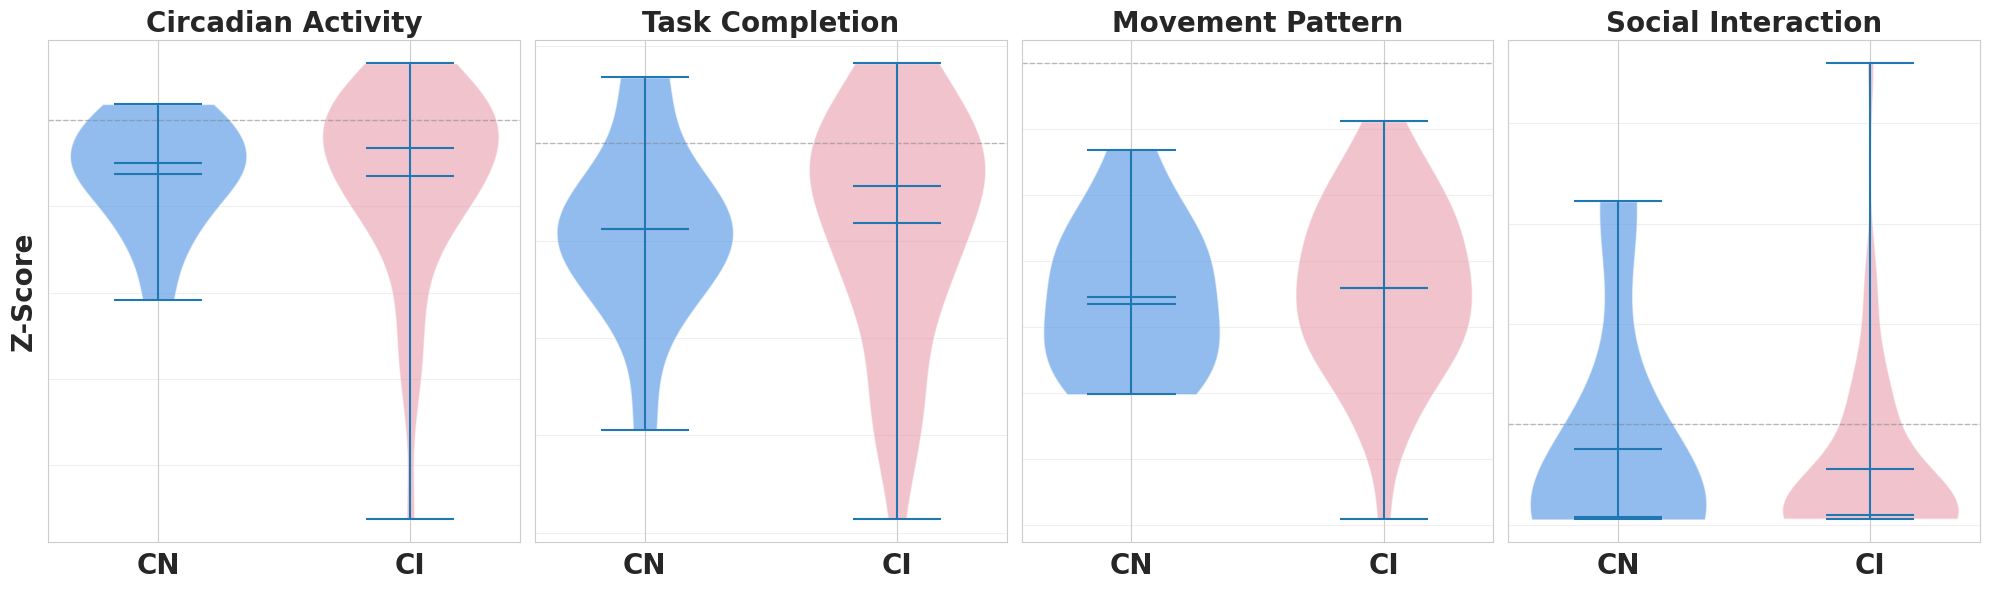

  ✓ Saved: violin_statistics.csv

✓ VIOLIN PLOT COMPLETED

Statistics Summary:
Dimension    CN_mean    CN_std    CI_mean    CI_std  p_value  cohens_d significance
Circadian  -0.622648  0.649016  -0.653797  1.098629 0.558940 -0.034523           ns
     Task  -0.438035  0.466910  -0.409526  0.589152 0.469624  0.053634           ns
 Movement -88.593694 28.506028 -85.428340 33.207235 0.641536  0.102286           ns
   Social  -0.123180  0.577195  -0.223852  0.449072 0.532603 -0.194680           ns



In [72]:
# ============================================================================
# CELL 1: Violin Plot Analysis (Using Trained Models)
# ============================================================================
print("="*80)
print("GENERATING VIOLIN PLOTS")
print("="*80)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Decide which model to use
print("\nAvailable models:")
print("  1. trained_model_without_personalization.pt")
print("  2. trained_model_with_personalization.pt")

# Load WITHOUT personalization model (you can change this)
MODEL_PATH = 'trained_model_without_personalization.pt'
print(f"\n📂 Loading model: {MODEL_PATH}")

checkpoint = torch.load(MODEL_PATH, map_location=device)

print(f"\n✓ Checkpoint loaded")
print(f"  Type: {checkpoint['config']['type']}")
print(f"  Weights: {checkpoint['config'].get('weights_name', 'N/A')}")
print(f"  Train ratio: {checkpoint['config']['cn_train_ratio']}")
print(f"  Val loss: {checkpoint['training']['val_loss']:.4f}")

# Load model
from ctms_model_gpu import CTMSModelGPU

model = CTMSModelGPU(
    d_model=checkpoint['config']['d_model'],
    num_activities=checkpoint['config']['num_activities'],
    num_task_templates=checkpoint['config'].get('num_task_templates', 20),
    use_fast_similarity=True
).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Model loaded and set to eval mode")

# Get data split from checkpoint
train_cn_ids = checkpoint['data_split']['train_cn_ids']
test_ids = checkpoint['data_split']['test_ids']

print(f"\nData split:")
print(f"  Train CN: {len(train_cn_ids)} subjects")
print(f"  Test: {len(test_ids)} subjects")

# Preprocess function
def preprocess_sequence(sequence, max_len=500):
    """Preprocess a single sequence"""
    seq = sequence[:max_len]
    
    acts = [s['action_id'] for s in seq]
    times = [s['ts'] for s in seq]
    
    if len(times) > 1:
        min_t, max_t = min(times), max(times)
        if max_t > min_t:
            times = [(t - min_t) / (max_t - min_t) for t in times]
        else:
            times = [0.0] * len(times)
    
    return torch.LongTensor(acts), torch.FloatTensor(times)

# Extract encodings for all TEST subjects
def get_dimension_encodings(model, sequences_dict, subject_ids, labels_dict, device):
    """Extract four-dimension encodings for subjects"""
    all_encodings = []
    
    for anon_id in subject_ids:
        if anon_id not in sequences_dict:
            continue
        
        raw_data = sequences_dict[anon_id]
        if not raw_data:
            continue
        
        all_acts = []
        all_times = []
        
        try:
            for month_data in raw_data:
                acts, times = preprocess_sequence(month_data['sequence'])
                all_acts.append(acts)
                all_times.append(times)
            
            if not all_acts:
                continue
            
            activity_ids = nn.utils.rnn.pad_sequence(all_acts, batch_first=True, padding_value=0)
            timestamps = nn.utils.rnn.pad_sequence(all_times, batch_first=True, padding_value=0.0)
            
            activity_ids = activity_ids.to(device)
            timestamps = timestamps.to(device)
            
            with torch.no_grad():
                outputs = model(activity_ids, timestamps, return_encodings_only=True)
                
                h_c = outputs['h_c'].cpu().numpy()
                h_t = outputs['h_t'].cpu().numpy()
                h_m = outputs['h_m'].cpu().numpy()
                h_s = outputs['h_s'].cpu().numpy()
                
                all_encodings.append({
                    'anon_id': anon_id,
                    'label': labels_dict[anon_id]['label'],
                    'circadian': np.mean(np.linalg.norm(h_c, axis=1)),
                    'task': np.mean(np.linalg.norm(h_t, axis=1)),
                    'movement': np.mean(np.linalg.norm(h_m, axis=1)),
                    'social': np.mean(np.linalg.norm(h_s, axis=1))
                })
            
            print(f"  ✓ {anon_id} ({labels_dict[anon_id]['label']}): {len(all_acts)} months")
            
        except Exception as e:
            print(f"  ❌ {anon_id}: Error - {str(e)}")
            continue
    
    return pd.DataFrame(all_encodings)

print(f"\n📄 Extracting encodings from TEST subjects...")
df_encodings = get_dimension_encodings(model, sequences, test_ids, labels, device)

print(f"\n✅ Extracted encodings for {len(df_encodings)} subjects")
print(f"  CN: {len(df_encodings[df_encodings['label']=='CN'])}")
print(f"  CI: {len(df_encodings[df_encodings['label']=='CI'])}")

# Reshape for violin plot
plot_data = []
for _, row in df_encodings.iterrows():
    for dim in ['circadian', 'task', 'movement', 'social']:
        plot_data.append({
            'subject_id': row['anon_id'],
            'label': row['label'],
            'dimension': dim.capitalize(),
            'encoding': row[dim]
        })

df_plot = pd.DataFrame(plot_data)

# Compute Z-scores normalized to CN baseline (from checkpoint or compute fresh)
print(f"\n📊 Computing Z-scores...")

# Use baseline from checkpoint if available
if 'baseline_stats' in checkpoint:
    baseline = {}
    for dim in ['circadian', 'task', 'movement', 'social']:
        baseline[dim.capitalize()] = {
            'mean': checkpoint['baseline_stats'][dim]['mean'],
            'std': checkpoint['baseline_stats'][dim]['std']
        }
    print("  Using baseline from checkpoint")
else:
    # Compute from CN data
    cn_data = df_plot[df_plot['label'] == 'CN']
    baseline = {}
    for dim in ['Circadian', 'Task', 'Movement', 'Social']:
        dim_data = cn_data[cn_data['dimension'] == dim]['encoding']
        baseline[dim] = {
            'mean': dim_data.mean(),
            'std': dim_data.std()
        }
    print("  Computing baseline from CN test data")

for dim in ['Circadian', 'Task', 'Movement', 'Social']:
    print(f"  {dim}: mean={baseline[dim]['mean']:.3f}, std={baseline[dim]['std']:.3f}")

df_plot['z_score'] = df_plot.apply(
    lambda row: (row['encoding'] - baseline[row['dimension']]['mean']) / baseline[row['dimension']]['std'],
    axis=1
)

# Re-filter after adding z_score
cn_data = df_plot[df_plot['label'] == 'CN']
ci_data = df_plot[df_plot['label'] == 'CI']

# Statistical testing
print(f"\n📈 Statistical testing...")
stats_results = []
for dim in ['Circadian', 'Task', 'Movement', 'Social']:
    cn_vals = cn_data[cn_data['dimension'] == dim]['z_score']
    ci_vals = ci_data[ci_data['dimension'] == dim]['z_score']
    
    if len(cn_vals) == 0 or len(ci_vals) == 0:
        continue
    
    statistic, p_value = stats.mannwhitneyu(cn_vals, ci_vals, alternative='two-sided')
    cohens_d = (ci_vals.mean() - cn_vals.mean()) / np.sqrt((cn_vals.std()**2 + ci_vals.std()**2) / 2)
    
    sig = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else 'ns'))
    
    stats_results.append({
        'Dimension': dim,
        'CN_mean': cn_vals.mean(),
        'CN_std': cn_vals.std(),
        'CI_mean': ci_vals.mean(),
        'CI_std': ci_vals.std(),
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significance': sig
    })
    
    print(f"  {dim:12s}: CN={cn_vals.mean():>6.3f}±{cn_vals.std():.3f}, "
          f"CI={ci_vals.mean():>6.3f}±{ci_vals.std():.3f}, "
          f"p={p_value:.4f} {sig}")

stats_df = pd.DataFrame(stats_results)

# Create violin plot
print(f"\n🎨 Creating violin plot...")
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
colors = {'CN': '#4A90E2', 'CI': '#E89DAC'}


name_map = {
    'Circadian': 'Circadian Activity',
    'Task': 'Task Completion',
    'Movement': 'Movement Pattern',
    'Social': 'Social Interaction'
}

for idx, dim in enumerate(['Circadian', 'Task', 'Movement', 'Social']):
    ax = axes[idx]
    
    dim_data = df_plot[df_plot['dimension'] == dim]
    
    parts = ax.violinplot(
        [dim_data[dim_data['label'] == 'CN']['z_score'],
         dim_data[dim_data['label'] == 'CI']['z_score']],
        positions=[0, 1],
        widths=0.7,
        showmeans=True,
        showmedians=True
    )
    
    for i, (pc, label) in enumerate(zip(parts['bodies'], ['CN', 'CI'])):
        pc.set_facecolor(colors[label])
        pc.set_alpha(0.6)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['CN', 'CI'],fontsize=20, fontweight='bold')
    ax.set_ylabel('Z-Score' if idx == 0 else '',fontsize=20, fontweight='bold')
    ax.set_title(name_map[dim], fontsize=20, fontweight='bold')
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(axis='y', alpha=0.3)
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    dim_stats = stats_df[stats_df['Dimension'] == dim]
    if len(dim_stats) > 0:
        p_val = dim_stats['p_value'].values[0]
        sig = dim_stats['significance'].values[0]
        # ax.text(0.5, ax.get_ylim()[1] * 0.95, f'p = {p_val:.4f} {sig}',
        #        ha='center', va='top', fontsize=12, fontweight='bold')

#plt.suptitle(f'Four-Dimension CTMS Encoding Comparison (n={len(df_encodings)})', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()

#plt.savefig('violin_plots.png', dpi=300, bbox_inches='tight')
#print(f"  ✓ Saved: violin_plots.png")
plt.show()

stats_df.to_csv('violin_statistics.csv', index=False)
print(f"  ✓ Saved: violin_statistics.csv")

print(f"\n{'='*80}")
print(f"✓ VIOLIN PLOT COMPLETED")
print(f"{'='*80}")
print("\nStatistics Summary:")
print(stats_df.to_string(index=False))
print(f"\n{'='*80}")

In [ ]:
print("\n" + "="*80)
print("GENERATING DAILY PATTERN")
print("="*80)

import math

# Model is already loaded from Cell 1
print(f"\n📂 Using model: {MODEL_PATH}")
print(f"  Train CN: {len(train_cn_ids)} subjects")
print(f"  Test: {len(test_ids)} subjects")

# Separate test into CN and CI
test_cn_ids = [aid for aid in test_ids if aid in labels and labels[aid]['label'] == 'CN']
test_ci_ids = [aid for aid in test_ids if aid in labels and labels[aid]['label'] == 'CI']

print(f"  Test CN: {len(test_cn_ids)}")
print(f"  Test CI: {len(test_ci_ids)}")

# Configuration
START_HOUR = 6.5
END_HOUR = 19.5
BIN_MINUTES = 30
BIN_WIDTH = BIN_MINUTES / 60.0
NUM_BINS = int(math.ceil((END_HOUR - START_HOUR) / BIN_WIDTH))
BIN_EDGES = np.array([START_HOUR + i * BIN_WIDTH for i in range(NUM_BINS + 1)])
TIME_CENTERS = (BIN_EDGES[:-1] + BIN_EDGES[1:]) / 2.0

ANOMALY_THRESHOLD = 2.0
USE_ABS_Z = False
SEQ_LEN = 30
STRIDE = 10

# Get fusion weights from checkpoint
if checkpoint['config']['type'] == 'with_personalization':
    alpha = np.array([0.25, 0.25, 0.25, 0.25])  # Default
    print(f"\n⚠️  Using WITH personalization model - will use equal weights for averaging")
else:
    alpha = np.array(checkpoint['config']['weights'])
    print(f"\nFusion weights: {alpha}")

print(f"\nParameters:")
print(f"  Time range: {START_HOUR:.1f} - {END_HOUR:.1f} ({NUM_BINS} bins)")
print(f"  Anomaly threshold: {ANOMALY_THRESHOLD} std")
print(f"  Use ABS z-score: {USE_ABS_Z}")

# Helper function
def extract_windows(events, seq_len=30, stride=10):
    """Extract sliding windows from event sequence"""
    if len(events) < seq_len:
        return []
    
    timestamps = np.array([e['ts'] for e in events])
    hours = (timestamps % 86400) / 3600.0
    actions = np.array([e['action_id'] for e in events])
    
    windows = []
    for start in range(0, len(events) - seq_len + 1, stride):
        end = start + seq_len
        acts_slice = actions[start:end]
        hours_slice = hours[start:end]
        
        if len(acts_slice) != seq_len:
            continue
        
        center_hour = float(hours_slice[len(hours_slice) // 2])
        
        min_t, max_t = timestamps[start], timestamps[end-1]
        if max_t > min_t:
            times_norm = (timestamps[start:end] - min_t) / (max_t - min_t)
        else:
            times_norm = np.zeros(seq_len)
        
        windows.append({
            'actions': acts_slice,
            'times': times_norm.astype(np.float32),
            'center_hour': center_hour
        })
    
    return windows



GENERATING DAILY PATTERN WITH ADAPTIVE ANOMALY DETECTION

📁 Created output directory: abnormalTS/

Fusion weights: [0.1 0.1 0.7 0.1]

Parameters:
  Time range: 9.0 - 19.5 (21 bins)
  Anomaly percentile: 90th (top 10%)

📊 Step 1: Loading baseline statistics...
  Using baseline from checkpoint:
  Circadian   : mean=9.766, std=0.057
  Task        : mean=31.398, std=0.685
  Movement    : mean=146.234, std=0.616
  Social      : mean=73.094, std=143.864

📄 Step 2: Extracting test windows...
  Total test windows: 5992

📈 Step 3: Computing all anomaly scores to determine threshold...

  Score statistics:
    Min: 0.0000
    Max: 0.0863
    Mean: 0.0132
    Median: 0.0000
    90th percentile: 0.0671

  🎯 Using adaptive threshold: 0.0671
     (This will flag top 10% of windows)

💾 Step 4: Detecting and saving anomalies...

  Pattern statistics:
    CN: avg=0.0084, peak at 19.2h
    CI: avg=0.0104, peak at 18.2h

💾 Step 5: Saving abnormal timestamps to files...
  ✓ 46: 270 abnormal timestamps
  

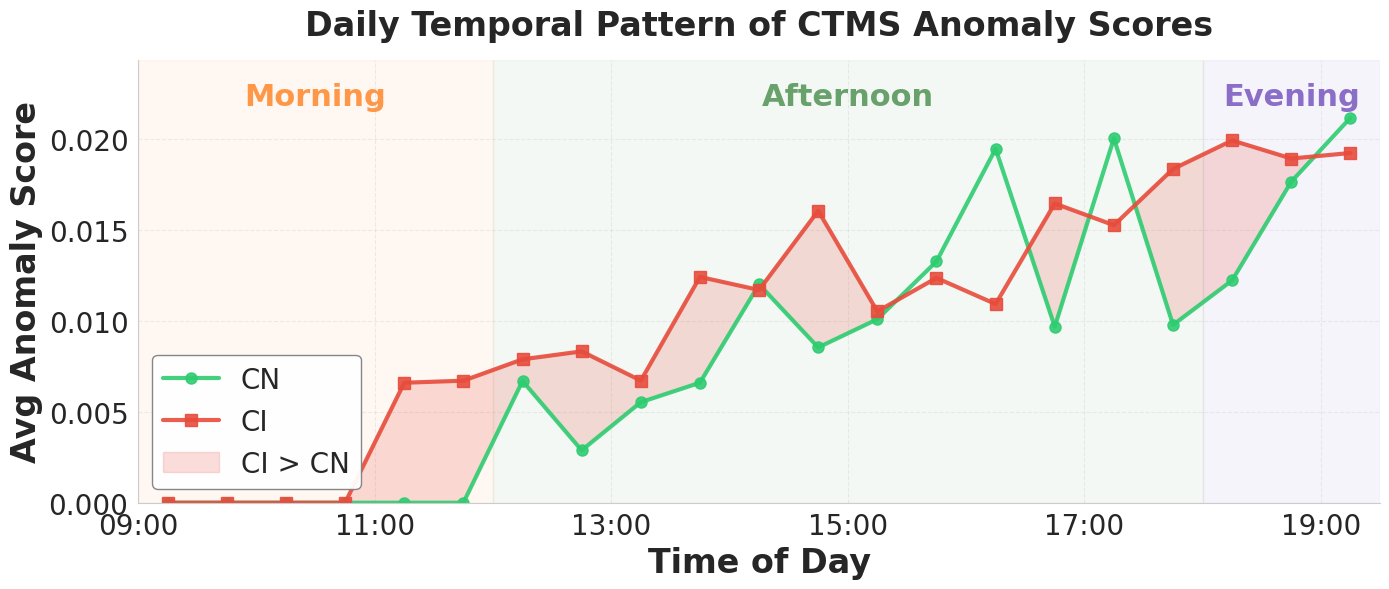


✓ COMPLETED WITH ADAPTIVE THRESHOLD

Key Results:
  Adaptive threshold: 0.0671 (90th percentile)
  Subjects with anomalies: 20
  Total abnormal timestamps: 10320
  Avg timestamps per subject: 516.0
  Output directory: abnormalTS/


In [73]:
# ============================================================================
# CELL 2B: Daily Temporal Pattern with Adaptive Threshold
# ============================================================================
print("\n" + "="*80)
print("GENERATING DAILY PATTERN WITH ADAPTIVE ANOMALY DETECTION")
print("="*80)

import math
import os
import json
from collections import defaultdict

# Configuration
START_HOUR = 9.0
END_HOUR = 19.5
BIN_MINUTES = 30
BIN_WIDTH = BIN_MINUTES / 60.0
NUM_BINS = int(math.ceil((END_HOUR - START_HOUR) / BIN_WIDTH))
BIN_EDGES = np.array([START_HOUR + i * BIN_WIDTH for i in range(NUM_BINS + 1)])
TIME_CENTERS = (BIN_EDGES[:-1] + BIN_EDGES[1:]) / 2.0

# Use percentile-based threshold instead of fixed value
ANOMALY_PERCENTILE = 90  # Top 10% will be considered anomalous
USE_ABS_Z = False
SEQ_LEN = 30
STRIDE = 10

# Create output directory
OUTPUT_DIR = 'abnormalTS'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\n📁 Created output directory: {OUTPUT_DIR}/")

# Get fusion weights
if checkpoint['config']['type'] == 'with_personalization':
    alpha = np.array([0.25, 0.25, 0.25, 0.25])
    print(f"\n⚠️  Using WITH personalization model - will use equal weights")
else:
    alpha = np.array(checkpoint['config']['weights'])
    print(f"\nFusion weights: {alpha}")

print(f"\nParameters:")
print(f"  Time range: {START_HOUR:.1f} - {END_HOUR:.1f} ({NUM_BINS} bins)")
print(f"  Anomaly percentile: {ANOMALY_PERCENTILE}th (top {100-ANOMALY_PERCENTILE}%)")

# Helper function
def extract_windows(events, seq_len=30, stride=10):
    """Extract sliding windows from event sequence"""
    if len(events) < seq_len:
        return []
    
    timestamps = np.array([e['ts'] for e in events])
    hours = (timestamps % 86400) / 3600.0
    actions = np.array([e['action_id'] for e in events])
    
    windows = []
    for start in range(0, len(events) - seq_len + 1, stride):
        end = start + seq_len
        acts_slice = actions[start:end]
        hours_slice = hours[start:end]
        
        if len(acts_slice) != seq_len:
            continue
        
        center_hour = float(hours_slice[len(hours_slice) // 2])
        
        min_t, max_t = timestamps[start], timestamps[end-1]
        if max_t > min_t:
            times_norm = (timestamps[start:end] - min_t) / (max_t - min_t)
        else:
            times_norm = np.zeros(seq_len)
        
        windows.append({
            'actions': acts_slice,
            'times': times_norm.astype(np.float32),
            'center_hour': center_hour,
            'window_start_idx': start,
            'window_end_idx': end,
            'timestamps': timestamps[start:end].copy()
        })
    
    return windows

# Step 1: Get baseline stats
print(f"\n📊 Step 1: Loading baseline statistics...")
if 'baseline_stats' in checkpoint:
    baseline_stats = checkpoint['baseline_stats']
    print("  Using baseline from checkpoint:")
else:
    print("  ERROR: No baseline stats in checkpoint!")
    print("  Please compute baseline first")

for dim in ['circadian', 'task', 'movement', 'social']:
    print(f"  {dim.capitalize():12s}: mean={baseline_stats[dim]['mean']:.3f}, std={baseline_stats[dim]['std']:.3f}")

# Step 2: Extract test windows
print(f"\n📄 Step 2: Extracting test windows...")
test_windows_all = []

for anon_id in test_cn_ids + test_ci_ids:
    if anon_id not in sequences:
        continue
    
    label = 'CN' if anon_id in test_cn_ids else 'CI'
    
    for month_data in sequences[anon_id]:
        events = month_data['sequence']
        windows = extract_windows(events, SEQ_LEN, STRIDE)
        
        for win in windows:
            test_windows_all.append({
                'subject_id': anon_id,
                'label': label,
                'window': win
            })

print(f"  Total test windows: {len(test_windows_all)}")

# Step 3: Compute all anomaly scores FIRST to determine threshold
print(f"\n📈 Step 3: Computing all anomaly scores to determine threshold...")

all_scores = []
batch_size = 64

for i in range(0, len(test_windows_all), batch_size):
    batch_data = test_windows_all[i:i+batch_size]
    batch = [item['window'] for item in batch_data]
    
    acts = np.array([w['actions'] for w in batch])
    times = np.array([w['times'] for w in batch])
    
    acts = torch.tensor(acts, dtype=torch.long).to(device)
    times = torch.tensor(times, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        outputs = model(acts, times, return_encodings_only=True)
        
        norms = {
            'circadian': torch.norm(outputs['h_c'], dim=1).cpu().numpy(),
            'task': torch.norm(outputs['h_t'], dim=1).cpu().numpy(),
            'movement': torch.norm(outputs['h_m'], dim=1).cpu().numpy(),
            'social': torch.norm(outputs['h_s'], dim=1).cpu().numpy()
        }
        
        for j, win in enumerate(batch):
            hour = win['center_hour']
            
            if hour < START_HOUR or hour >= END_HOUR:
                continue
            
            z_scores = []
            for dim in ['circadian', 'task', 'movement', 'social']:
                mu = baseline_stats[dim]['mean']
                sigma = baseline_stats[dim]['std']
                z = (norms[dim][j] - mu) / sigma
                if USE_ABS_Z:
                    z = abs(z)
                else:
                    z = max(0, z)
                z_scores.append(z)
            
            z_scores = np.array(z_scores)
            combined_score = float(np.sum(alpha * z_scores))
            
            if np.isfinite(combined_score):
                all_scores.append(combined_score)

all_scores = np.array(all_scores)

# Determine adaptive threshold
ANOMALY_THRESHOLD = float(np.percentile(all_scores, ANOMALY_PERCENTILE))

print(f"\n  Score statistics:")
print(f"    Min: {np.min(all_scores):.4f}")
print(f"    Max: {np.max(all_scores):.4f}")
print(f"    Mean: {np.mean(all_scores):.4f}")
print(f"    Median: {np.median(all_scores):.4f}")
print(f"    {ANOMALY_PERCENTILE}th percentile: {ANOMALY_THRESHOLD:.4f}")
print(f"\n  🎯 Using adaptive threshold: {ANOMALY_THRESHOLD:.4f}")
print(f"     (This will flag top {100-ANOMALY_PERCENTILE}% of windows)")

# Step 4: Second pass - collect anomalies and compute patterns
print(f"\n💾 Step 4: Detecting and saving anomalies...")

exposure_counts = {'CN': np.zeros(NUM_BINS), 'CI': np.zeros(NUM_BINS)}
anomaly_counts = {'CN': np.zeros(NUM_BINS), 'CI': np.zeros(NUM_BINS)}
score_sums = {'CN': np.zeros(NUM_BINS), 'CI': np.zeros(NUM_BINS)}
abnormal_data = defaultdict(list)

for i in range(0, len(test_windows_all), batch_size):
    batch_data = test_windows_all[i:i+batch_size]
    batch = [item['window'] for item in batch_data]
    
    acts = np.array([w['actions'] for w in batch])
    times = np.array([w['times'] for w in batch])
    
    acts = torch.tensor(acts, dtype=torch.long).to(device)
    times = torch.tensor(times, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        outputs = model(acts, times, return_encodings_only=True)
        
        norms = {
            'circadian': torch.norm(outputs['h_c'], dim=1).cpu().numpy(),
            'task': torch.norm(outputs['h_t'], dim=1).cpu().numpy(),
            'movement': torch.norm(outputs['h_m'], dim=1).cpu().numpy(),
            'social': torch.norm(outputs['h_s'], dim=1).cpu().numpy()
        }
        
        for j, (item, win) in enumerate(zip(batch_data, batch)):
            subject_id = item['subject_id']
            label = item['label']
            hour = win['center_hour']
            
            if hour < START_HOUR or hour >= END_HOUR:
                continue
            
            bin_idx = int((hour - START_HOUR) / BIN_WIDTH)
            bin_idx = min(max(bin_idx, 0), NUM_BINS - 1)
            
            z_scores_dict = {}
            z_scores = []
            for dim in ['circadian', 'task', 'movement', 'social']:
                mu = baseline_stats[dim]['mean']
                sigma = baseline_stats[dim]['std']
                z = (norms[dim][j] - mu) / sigma
                z_raw = z
                if USE_ABS_Z:
                    z = abs(z)
                else:
                    z = max(0, z)
                z_scores.append(z)
                z_scores_dict[dim] = float(z_raw)
            
            z_scores = np.array(z_scores)
            combined_score = float(np.sum(alpha * z_scores))
            
            if not np.isfinite(combined_score):
                continue
            
            exposure_counts[label][bin_idx] += 1
            score_sums[label][bin_idx] += combined_score
            
            # Check if anomaly
            if combined_score >= ANOMALY_THRESHOLD:
                anomaly_counts[label][bin_idx] += 1
                
                # Record each timestamp in the window
                for ts_idx, ts in enumerate(win['timestamps']):
                    abnormal_data[subject_id].append({
                        'timestamp': int(ts),
                        'timestamp_readable': pd.to_datetime(ts, unit='s').strftime('%Y-%m-%d %H:%M:%S'),
                        'action_id': int(win['actions'][ts_idx]),
                        'window_center_hour': float(hour),
                        'anomaly_score': float(combined_score),
                        'z_scores': z_scores_dict,
                        'time_bin': int(bin_idx),
                        'label': label
                    })

# Compute patterns
cn_pattern = np.array([score_sums['CN'][i] / exposure_counts['CN'][i] if exposure_counts['CN'][i] > 0 else 0 
                       for i in range(NUM_BINS)])
ci_pattern = np.array([score_sums['CI'][i] / exposure_counts['CI'][i] if exposure_counts['CI'][i] > 0 else 0 
                       for i in range(NUM_BINS)])

print(f"\n  Pattern statistics:")
print(f"    CN: avg={np.mean(cn_pattern):.4f}, peak at {TIME_CENTERS[np.argmax(cn_pattern)]:.1f}h")
print(f"    CI: avg={np.mean(ci_pattern):.4f}, peak at {TIME_CENTERS[np.argmax(ci_pattern)]:.1f}h")

# Save abnormal timestamps
print(f"\n💾 Step 5: Saving abnormal timestamps to files...")
total_subjects_with_anomalies = 0
total_anomalous_timestamps = 0

for subject_id, anomaly_list in abnormal_data.items():
    if len(anomaly_list) > 0:
        # Sort by timestamp
        anomaly_list_sorted = sorted(anomaly_list, key=lambda x: x['timestamp'])
        
        # Create output file
        output_file = os.path.join(OUTPUT_DIR, f'{subject_id}_abnormal_timestamps.json')
        
        output_data = {
            'subject_id': subject_id,
            'label': anomaly_list_sorted[0]['label'],
            'total_abnormal_timestamps': len(anomaly_list_sorted),
            'abnormal_timestamps': anomaly_list_sorted,
            'metadata': {
                'anomaly_threshold': ANOMALY_THRESHOLD,
                'anomaly_percentile': ANOMALY_PERCENTILE,
                'time_range': f'{START_HOUR:.1f}h - {END_HOUR:.1f}h',
                'fusion_weights': alpha.tolist(),
                'use_abs_z': USE_ABS_Z
            }
        }
        
        with open(output_file, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        total_subjects_with_anomalies += 1
        total_anomalous_timestamps += len(anomaly_list_sorted)
        
        if total_subjects_with_anomalies <= 5:  # Show first 5 as examples
            print(f"  ✓ {subject_id}: {len(anomaly_list_sorted)} abnormal timestamps")

if total_subjects_with_anomalies > 5:
    print(f"  ... and {total_subjects_with_anomalies - 5} more subjects")

print(f"\n  📊 Summary:")
print(f"    Total subjects with anomalies: {total_subjects_with_anomalies}")
print(f"    Total abnormal timestamps: {total_anomalous_timestamps}")

# Create summary file
summary_data = {
    'total_subjects_analyzed': len(test_cn_ids) + len(test_ci_ids),
    'test_cn_subjects': len(test_cn_ids),
    'test_ci_subjects': len(test_ci_ids),
    'subjects_with_anomalies': total_subjects_with_anomalies,
    'total_abnormal_timestamps': total_anomalous_timestamps,
    'anomaly_threshold': float(ANOMALY_THRESHOLD),
    'anomaly_percentile': ANOMALY_PERCENTILE,
    'time_range': f'{START_HOUR:.1f}h - {END_HOUR:.1f}h',
    'subjects_by_label': {
        'CN': len([s for s in abnormal_data.keys() if s in test_cn_ids]),
        'CI': len([s for s in abnormal_data.keys() if s in test_ci_ids])
    },
    'score_statistics': {
        'min': float(np.min(all_scores)),
        'max': float(np.max(all_scores)),
        'mean': float(np.mean(all_scores)),
        'median': float(np.median(all_scores)),
        'std': float(np.std(all_scores))
    }
}

summary_file = os.path.join(OUTPUT_DIR, 'summary.json')
with open(summary_file, 'w') as f:
    json.dump(summary_data, f, indent=2)
print(f"  ✓ Summary saved: {summary_file}")

# Visualization
print(f"\n🎨 Creating visualization...")

fig, ax = plt.subplots(figsize=(14, 6))

cn_color = '#2ECC71'
ci_color = '#E74C3C'

ax.plot(TIME_CENTERS, cn_pattern, color=cn_color, linewidth=3, marker='o', 
        markersize=8, alpha=0.9, label='CN')
ax.plot(TIME_CENTERS, ci_pattern, color=ci_color, linewidth=3, marker='s', 
        markersize=8, alpha=0.9, label='CI')

ax.fill_between(TIME_CENTERS, cn_pattern, ci_pattern,
                where=ci_pattern >= cn_pattern,
                color=ci_color, alpha=0.18, interpolate=True, label='CI > CN')

ax.set_xlabel('Time of Day', fontsize=24, fontweight='bold')
ax.set_ylabel('Avg Anomaly Score', fontsize=24, fontweight='bold')
ax.set_title('Daily Temporal Pattern of CTMS Anomaly Scores', 
            fontsize=24, fontweight='bold', pad=18)
ax.set_xlim(START_HOUR, END_HOUR)

tick_hours = np.arange(math.ceil(START_HOUR), END_HOUR + 1e-6, 2.0)
tick_hours = tick_hours[(tick_hours >= START_HOUR) & (tick_hours <= END_HOUR)]
ax.set_xticks(tick_hours)
tick_labels = [f"{int(th):02d}:00" for th in tick_hours]
ax.set_xticklabels(tick_labels, fontsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.35, linewidth=0.8)
ax.set_axisbelow(True)

ylim_top = max(np.max(cn_pattern), np.max(ci_pattern))
ylim_top = ylim_top * 1.15 if ylim_top > 0 else 1.0
ax.set_ylim(0, ylim_top)

label_y = ylim_top * 0.95
shade_periods = [
    ('Morning', START_HOUR, 12.0, '#FF6F00', 0.05),
    ('Afternoon', 12.0, 18.0, '#2E7D32', 0.05),
    ('Evening', 18.0, END_HOUR, '#5E35B1', 0.05),
]
for name, start, end, color, alpha_val in shade_periods:
    ax.axvspan(start, end, color=color, alpha=alpha_val, zorder=-1)
    ax.text((start + end) / 2, label_y, name, fontsize=22, fontweight='bold',
            color=color, ha='center', va='top', alpha=0.7)

ax.legend(loc='lower left', fontsize=20, framealpha=0.95, fancybox=True, edgecolor='gray')
plt.tight_layout()

plt.savefig('daily_pattern_adaptive.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: daily_pattern_adaptive.png")
plt.show()

print(f"\n{'='*80}")
print(f"✓ COMPLETED WITH ADAPTIVE THRESHOLD")
print(f"{'='*80}")
print(f"\nKey Results:")
print(f"  Adaptive threshold: {ANOMALY_THRESHOLD:.4f} ({ANOMALY_PERCENTILE}th percentile)")
print(f"  Subjects with anomalies: {total_subjects_with_anomalies}")
print(f"  Total abnormal timestamps: {total_anomalous_timestamps}")
print(f"  Avg timestamps per subject: {total_anomalous_timestamps/max(total_subjects_with_anomalies,1):.1f}")
print(f"  Output directory: {OUTPUT_DIR}/")
print(f"{'='*80}")


ENHANCED MEDICAL CORRELATION ANALYSIS

📂 Using model: trained_model_without_personalization.pt
  Test subjects: 55

📊 Checking available scores in data...

Score availability:
  MoCA (Cognition)              :  44 subjects
  ZBI (Caregiver Burden)        :  22 subjects
  DSS (Digit Symbol Substitution):  18 subjects
  FAS (Fluency Assessment of Speech):  18 subjects

📄 Extracting encodings and scores...
  ✓ 46 (CN): moca=27.0, zbi=6.0, dss=5.0, fas=35.0
  ✓ 41 (CN): moca=25.0, zbi=2.0, dss=8.0, fas=43.0
  ✓ 47 (CN): moca=27.0
  ✓ 2 (CN): moca=25.0, zbi=26.0, dss=13.0, fas=48.0
  ✓ 7 (CN): moca=25.0, zbi=19.0, dss=12.0, fas=50.0
  ✓ 42 (CN): moca=25.0, zbi=0.0, dss=13.0, fas=11.0
  ✓ 49 (CN): moca=26.0, zbi=10.0, dss=6.0, fas=25.0
  ✓ 35 (CN): moca=26.0
  ✓ 64 (CN): moca=6.0, zbi=48.0
  ✓ 9 (CN): moca=30.0
  ✓ 45 (CN): moca=27.0, zbi=20.0, dss=14.0, fas=49.0
  ✓ 1 (CI): moca=6.0, zbi=16.0, dss=5.0, fas=44.0
  ✓ 3 (CI): moca=17.0, zbi=19.0, dss=10.0, fas=41.0
  ✓ 4 (CI): moca=25.0, zbi=

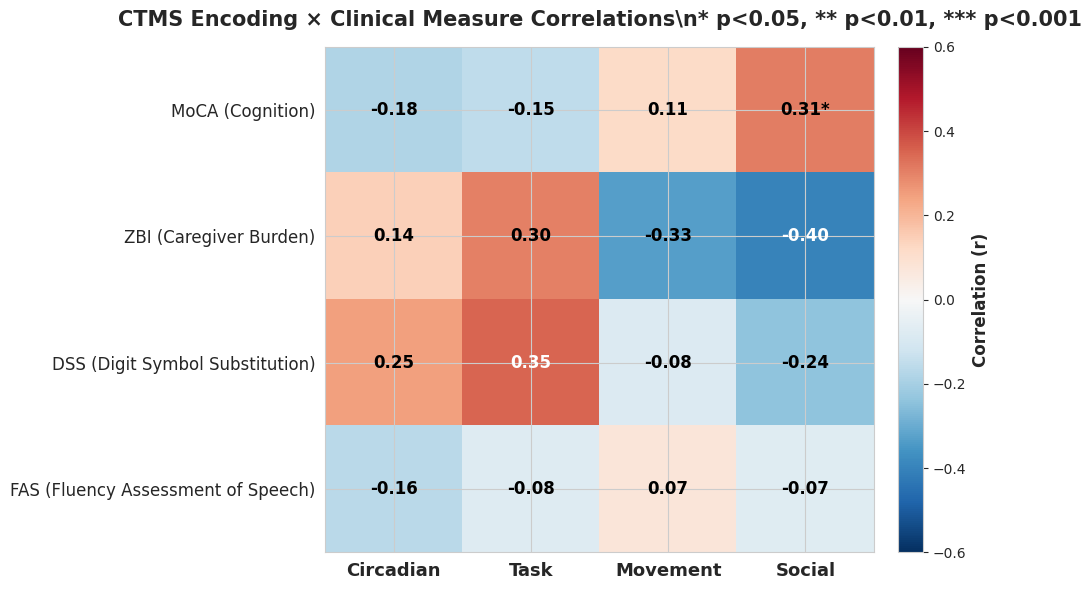


🎨 2. Composite score scatter plots...
  ✓ Saved: medical_composite_correlations.png


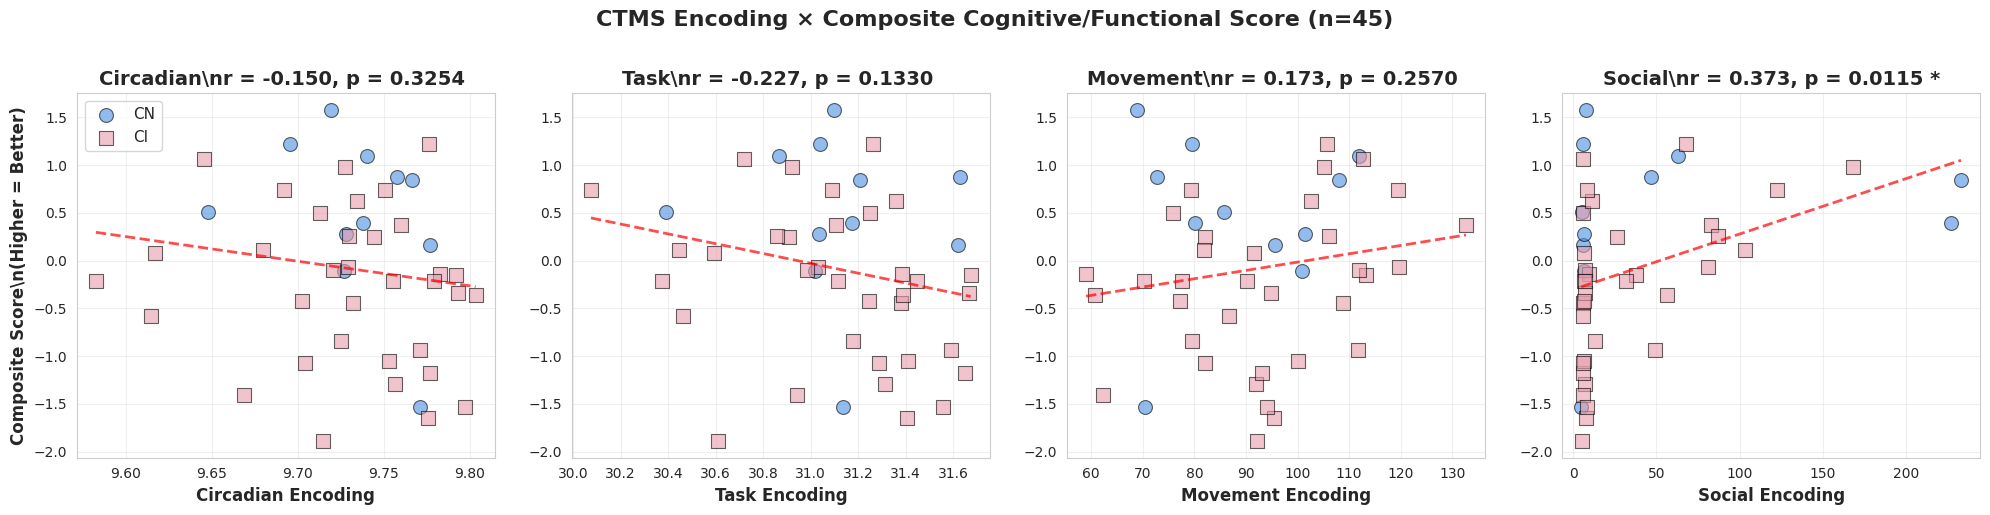


🎨 3. Top 1 significant correlations...
  ✓ Saved: medical_top_correlations.png


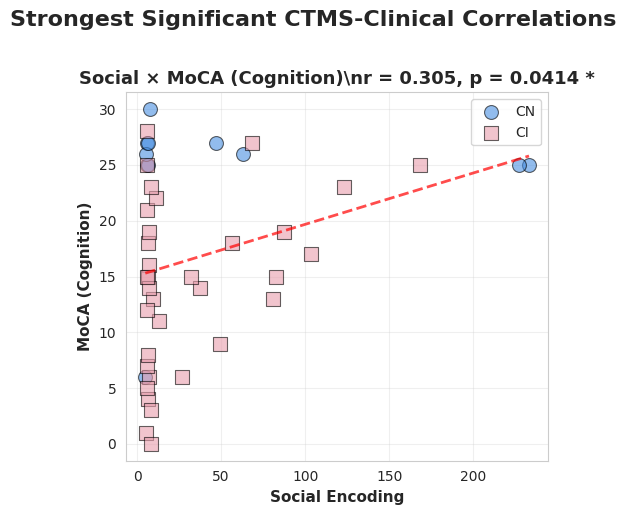


SUMMARY: KEY FINDINGS

📊 1. STRONGEST CORRELATIONS:
           Score Dimension       r        p sig  method
MoCA (Cognition)    Social 0.30536 0.041372   * Pearson

📊 2. COMPOSITE SCORE CORRELATIONS:
Dimension         r        p sig
Circadian -0.149983 0.325420    
     Task -0.227418 0.132994    
 Movement  0.172555 0.257008    
   Social  0.373363 0.011530   *

📊 3. SIGNIFICANT GROUP DIFFERENCES (CN vs CI):
   No significant group differences at p < 0.05

✓ Saved: medical_data_with_composite.csv
✓ Saved: medical_data_detailed.csv

✓ ENHANCED MEDICAL CORRELATION ANALYSIS COMPLETED

📁 Generated files:
   1. medical_correlations_detailed.csv
   2. medical_group_differences.csv
   3. medical_correlation_heatmap.png/pdf
   4. medical_composite_correlations.png/pdf
   5. medical_data_with_composite.csv
   6. medical_top_correlations.png
   7. medical_data_detailed.csv



In [74]:
# ============================================================================
# CELL 3: Enhanced Medical Score Correlation Analysis
# ============================================================================
print("\n" + "="*80)
print("ENHANCED MEDICAL CORRELATION ANALYSIS")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Model is already loaded from Cell 1
print(f"\n📂 Using model: {MODEL_PATH}")
print(f"  Test subjects: {len(test_ids)}")

# Define available medical scores
available_scores = ['moca', 'zbi', 'dss', 'fas']
score_names = {
    'moca': 'MoCA (Cognition)',
    'zbi': 'ZBI (Caregiver Burden)', 
    'dss': 'DSS (Digit Symbol Substitution)',
    'fas': 'FAS (Fluency Assessment of Speech)'
}

score_directions = {
    'moca': 1,   # Higher is better
    'zbi': -1,   # Higher is worse
    'dss': -1,   # Higher is worse
    'fas': 1     # Higher is better
}

# Check what scores are available in the data
print(f"\n📊 Checking available scores in data...")
score_availability = {}

for score in available_scores:
    count = 0
    for aid in test_ids:
        if aid not in labels:
            continue
        
        # Check in 'scores' dict
        if 'scores' in labels[aid] and score in labels[aid]['scores']:
            val = labels[aid]['scores'][score]
            if val is not None and not pd.isna(val) and val != 0:
                count += 1
        # Check at top level
        elif score in labels[aid]:
            val = labels[aid][score]
            if val is not None and not pd.isna(val) and val != 0:
                count += 1
        elif f'{score}_score' in labels[aid]:
            val = labels[aid][f'{score}_score']
            if val is not None and not pd.isna(val) and val != 0:
                count += 1
    
    score_availability[score] = count

print(f"\nScore availability:")
for score, count in score_availability.items():
    print(f"  {score_names[score]:30s}: {count:3d} subjects")

if not any(count >= 10 for count in score_availability.values()):
    raise ValueError(
        "\n❌ ERROR: Insufficient real medical score data available. "
        "At least one score must have ≥10 subjects with valid entries."
    )

# Extract encodings and all available scores
print(f"\n📄 Extracting encodings and scores...")

medical_data = []

for anon_id in test_ids:
    if anon_id not in sequences or anon_id not in labels:
        continue
    
    # Collect all available scores for this subject
    scores_dict = {}
    
    if 'scores' in labels[anon_id]:
        for score in available_scores:
            if score in labels[anon_id]['scores']:
                val = labels[anon_id]['scores'][score]
                if val is not None and not pd.isna(val):
                    scores_dict[score] = float(val)
    
    # Also check top-level
    for score in available_scores:
        if score not in scores_dict:
            val = labels[anon_id].get(score) or labels[anon_id].get(f'{score}_score')
            if val is not None and not pd.isna(val):
                scores_dict[score] = float(val)
    
    # Skip if no scores available
    if not scores_dict:
        continue
    
    raw_data = sequences[anon_id]
    if not raw_data:
        continue
    
    try:
        all_acts = []
        all_times = []
        
        for month_data in raw_data:
            acts, times = preprocess_sequence(month_data['sequence'])
            all_acts.append(acts)
            all_times.append(times)
        
        if not all_acts:
            continue
        
        activity_ids = nn.utils.rnn.pad_sequence(all_acts, batch_first=True, padding_value=0)
        timestamps = nn.utils.rnn.pad_sequence(all_times, batch_first=True, padding_value=0.0)
        
        activity_ids = activity_ids.to(device)
        timestamps = timestamps.to(device)
        
        with torch.no_grad():
            outputs = model(activity_ids, timestamps, return_encodings_only=True)
            
            h_c = outputs['h_c'].cpu().numpy()
            h_t = outputs['h_t'].cpu().numpy()
            h_m = outputs['h_m'].cpu().numpy()
            h_s = outputs['h_s'].cpu().numpy()
            
            record = {
                'anon_id': anon_id,
                'label': labels[anon_id]['label'],
                'circadian': np.mean(np.linalg.norm(h_c, axis=1)),
                'task': np.mean(np.linalg.norm(h_t, axis=1)),
                'movement': np.mean(np.linalg.norm(h_m, axis=1)),
                'social': np.mean(np.linalg.norm(h_s, axis=1))
            }
            record.update(scores_dict)
            medical_data.append(record)
        
        score_str = ", ".join([f"{s}={scores_dict.get(s, 'N/A'):.1f}" for s in available_scores if s in scores_dict])
        print(f"  ✓ {anon_id} ({labels[anon_id]['label']}): {score_str}")
        
    except Exception as e:
        print(f"  ❌ {anon_id}: {str(e)}")
        continue

df_medical = pd.DataFrame(medical_data)

print(f"\n✅ Extracted data for {len(df_medical)} subjects")
print(f"   CN: {len(df_medical[df_medical['label']=='CN'])}")
print(f"   CI: {len(df_medical[df_medical['label']=='CI'])}")

if len(df_medical) == 0:
    print(f"\n❌ ERROR: No subjects with medical data!")
else:
    # Determine valid scores (sufficient data)
    valid_scores = [s for s in available_scores if s in df_medical.columns and df_medical[s].notna().sum() >= 10]
    dims = ['circadian', 'task', 'movement', 'social']
    
    print(f"\n✓ Analyzing {len(valid_scores)} scores: {', '.join(valid_scores)}")
    
    # =========================================================================
    # ANALYSIS 1: Individual Correlations
    # =========================================================================
    print(f"\n{'='*80}")
    print("ANALYSIS 1: INDIVIDUAL CORRELATIONS (Pearson & Spearman)")
    print(f"{'='*80}")
    
    correlation_results = []
    
    for score in valid_scores:
        print(f"\n{score_names[score]}:")
        for dim in dims:
            mask = df_medical[score].notna()
            X = df_medical.loc[mask, dim].values
            y = df_medical.loc[mask, score].values
            
            if len(X) < 3:
                continue
            
            # Pearson (linear)
            r_p, p_p = stats.pearsonr(X, y)
            
            # Spearman (rank-based, robust to outliers)
            r_s, p_s = stats.spearmanr(X, y)
            
            # Use stronger correlation
            if abs(r_s) > abs(r_p):
                r, p, method = r_s, p_s, 'Spearman'
            else:
                r, p, method = r_p, p_p, 'Pearson'
            
            sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
            
            correlation_results.append({
                'Score': score_names[score],
                'score_key': score,
                'Dimension': dim.capitalize(),
                'r': r,
                'p': p,
                'sig': sig,
                'method': method,
                'n': len(X)
            })
            
            print(f"  {dim.capitalize():12s}: r={r:>6.3f}, p={p:.4f} {sig:3s} ({method}, n={len(X)})")
    
    corr_df = pd.DataFrame(correlation_results)
    corr_df.to_csv('medical_correlations_detailed.csv', index=False)
    print(f"\n✓ Saved: medical_correlations_detailed.csv")
    
    # =========================================================================
    # ANALYSIS 2: Composite Score (Multi-measure integration)
    # =========================================================================
    print(f"\n{'='*80}")
    print("ANALYSIS 2: COMPOSITE COGNITIVE/FUNCTIONAL SCORE")
    print(f"{'='*80}")
    
    composite_data = df_medical.copy()
    
    # Standardize and orient each score (higher = better)
    for score in valid_scores:
        if score in composite_data.columns:
            mask = composite_data[score].notna()
            values = composite_data.loc[mask, score].values
            
            if len(values) > 0 and values.std() > 0:
                # Standardize
                z_scores = (values - values.mean()) / values.std()
                # Apply direction (make all "higher = better")
                composite_data.loc[mask, f'{score}_std'] = z_scores * score_directions[score]
    
    # Create composite score (average of standardized scores)
    std_cols = [f'{s}_std' for s in valid_scores if f'{s}_std' in composite_data.columns]
    
    if len(std_cols) > 0:
        composite_data['composite_score'] = composite_data[std_cols].mean(axis=1)
        
        print(f"\nComposite score created from: {', '.join([score_names[s] for s in valid_scores])}")
        print(f"  CN mean: {composite_data[composite_data['label']=='CN']['composite_score'].mean():.3f}")
        print(f"  CI mean: {composite_data[composite_data['label']=='CI']['composite_score'].mean():.3f}")
        print(f"  Difference: {composite_data[composite_data['label']=='CN']['composite_score'].mean() - composite_data[composite_data['label']=='CI']['composite_score'].mean():.3f}")
        
        # Correlate composite with each dimension
        print(f"\nComposite Score Correlations:")
        composite_corr = []
        
        for dim in dims:
            mask = composite_data['composite_score'].notna()
            X = composite_data.loc[mask, dim].values
            y = composite_data.loc[mask, 'composite_score'].values
            
            r, p = stats.pearsonr(X, y)
            sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
            
            composite_corr.append({
                'Dimension': dim.capitalize(),
                'r': r,
                'p': p,
                'sig': sig
            })
            
            print(f"  {dim.capitalize():12s}: r={r:>6.3f}, p={p:.4f} {sig}")
        
        composite_corr_df = pd.DataFrame(composite_corr)
    else:
        print("⚠️  Could not create composite score")
        composite_corr_df = None
    
    # =========================================================================
    # ANALYSIS 3: Group Differences (CN vs CI)
    # =========================================================================
    print(f"\n{'='*80}")
    print("ANALYSIS 3: GROUP DIFFERENCES (CN vs CI)")
    print(f"{'='*80}")
    
    group_results = []
    
    for score in valid_scores:
        print(f"\n{score_names[score]}:")
        for dim in dims:
            mask = df_medical[score].notna()
            
            cn_vals = df_medical.loc[mask & (df_medical['label'] == 'CN'), dim].values
            ci_vals = df_medical.loc[mask & (df_medical['label'] == 'CI'), dim].values
            
            if len(cn_vals) >= 3 and len(ci_vals) >= 3:
                # Mann-Whitney U test
                stat, p = stats.mannwhitneyu(cn_vals, ci_vals, alternative='two-sided')
                
                # Cohen's d
                pooled_std = np.sqrt((cn_vals.std()**2 + ci_vals.std()**2) / 2)
                cohens_d = (ci_vals.mean() - cn_vals.mean()) / pooled_std if pooled_std > 0 else 0
                
                sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
                
                group_results.append({
                    'Score': score_names[score],
                    'Dimension': dim.capitalize(),
                    'CN_mean': cn_vals.mean(),
                    'CI_mean': ci_vals.mean(),
                    'diff': ci_vals.mean() - cn_vals.mean(),
                    'cohens_d': cohens_d,
                    'p': p,
                    'sig': sig
                })
                
                print(f"  {dim.capitalize():12s}: CN={cn_vals.mean():.2f}, CI={ci_vals.mean():.2f}, "
                      f"d={cohens_d:.2f}, p={p:.4f} {sig}")
    
    group_df = pd.DataFrame(group_results)
    group_df.to_csv('medical_group_differences.csv', index=False)
    print(f"\n✓ Saved: medical_group_differences.csv")
    
    # =========================================================================
    # VISUALIZATION 1: Correlation Heatmap
    # =========================================================================
    print(f"\n{'='*80}")
    print("CREATING VISUALIZATIONS")
    print(f"{'='*80}")
    
    print(f"\n🎨 1. Correlation heatmap...")
    
    # Build correlation matrix
    n_scores = len(valid_scores)
    n_dims = len(dims)
    corr_matrix = np.zeros((n_scores, n_dims))
    p_matrix = np.ones((n_scores, n_dims))
    
    for i, score in enumerate(valid_scores):
        for j, dim in enumerate(dims):
            rows = corr_df[(corr_df['score_key'] == score) & 
                          (corr_df['Dimension'] == dim.capitalize())]
            if len(rows) > 0:
                corr_matrix[i, j] = rows.iloc[0]['r']
                p_matrix[i, j] = rows.iloc[0]['p']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-0.6, vmax=0.6, aspect='auto')
    
    ax.set_xticks(np.arange(n_dims))
    ax.set_yticks(np.arange(n_scores))
    ax.set_xticklabels([d.capitalize() for d in dims], fontsize=13, fontweight='bold')
    ax.set_yticklabels([score_names[s] for s in valid_scores], fontsize=12)
    
    # Add values and significance
    for i in range(n_scores):
        for j in range(n_dims):
            r_val = corr_matrix[i, j]
            p_val = p_matrix[i, j]
            
            sig_str = '***' if p_val < 0.001 else ('**' if p_val < 0.01 else ('*' if p_val < 0.05 else ''))
            
            text_color = 'white' if abs(r_val) > 0.35 else 'black'
            text_str = f'{r_val:.2f}{sig_str}'
            
            ax.text(j, i, text_str, ha='center', va='center',
                   fontsize=12, fontweight='bold', color=text_color)
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation (r)', fontsize=12, fontweight='bold')
    
    ax.set_title('CTMS Encoding × Clinical Measure Correlations\\n* p<0.05, ** p<0.01, *** p<0.001',
                fontsize=15, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.savefig('medical_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.savefig('medical_correlation_heatmap.pdf', bbox_inches='tight')
    print(f"  ✓ Saved: medical_correlation_heatmap.png")
    plt.show()
    
    # =========================================================================
    # VISUALIZATION 2: Composite Score Plots
    # =========================================================================
    if composite_corr_df is not None and len(composite_data) > 0:
        print(f"\n🎨 2. Composite score scatter plots...")
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        for idx, dim in enumerate(dims):
            ax = axes[idx]
            
            mask = composite_data['composite_score'].notna()
            
            for label, color, marker in [('CN', '#4A90E2', 'o'), ('CI', '#E89DAC', 's')]:
                label_mask = mask & (composite_data['label'] == label)
                ax.scatter(composite_data.loc[label_mask, dim],
                          composite_data.loc[label_mask, 'composite_score'],
                          alpha=0.6, s=100, color=color, edgecolors='black',
                          linewidth=0.8, marker=marker, label=label)
            
            # Regression
            X_vals = composite_data.loc[mask, dim].values
            y_vals = composite_data.loc[mask, 'composite_score'].values
            
            z = np.polyfit(X_vals, y_vals, 1)
            p_fit = np.poly1d(z)
            x_line = np.linspace(X_vals.min(), X_vals.max(), 100)
            ax.plot(x_line, p_fit(x_line), 'r--', linewidth=2, alpha=0.7)
            
            # Stats
            dim_corr = composite_corr_df[composite_corr_df['Dimension'] == dim.capitalize()]
            if len(dim_corr) > 0:
                r = dim_corr.iloc[0]['r']
                p = dim_corr.iloc[0]['p']
                sig = dim_corr.iloc[0]['sig']
                
                ax.set_title(f'{dim.capitalize()}\\nr = {r:.3f}, p = {p:.4f} {sig}',
                            fontsize=14, fontweight='bold')
            
            ax.set_xlabel(f'{dim.capitalize()} Encoding', fontsize=12, fontweight='bold')
            if idx == 0:
                ax.set_ylabel('Composite Score\\n(Higher = Better)', fontsize=12, fontweight='bold')
            ax.grid(alpha=0.3)
            
            if idx == 0:
                ax.legend(loc='best', fontsize=11)
        
        plt.suptitle(f'CTMS Encoding × Composite Cognitive/Functional Score (n={len(composite_data)})',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        plt.savefig('medical_composite_correlations.png', dpi=300, bbox_inches='tight')
        #plt.savefig('medical_composite_correlations.pdf', bbox_inches='tight')
        print(f"  ✓ Saved: medical_composite_correlations.png")
        plt.show()
    
    # =========================================================================
    # VISUALIZATION 3: Top Significant Correlations
    # =========================================================================
    sig_corrs = corr_df[corr_df['p'] < 0.05].sort_values('r', key=abs, ascending=False)
    
    if len(sig_corrs) > 0:
        print(f"\n🎨 3. Top {min(4, len(sig_corrs))} significant correlations...")
        
        top_corrs = sig_corrs.head(min(4, len(sig_corrs)))
        
        n_plots = len(top_corrs)
        fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
        if n_plots == 1:
            axes = [axes]
        
        for idx, (_, row) in enumerate(top_corrs.iterrows()):
            ax = axes[idx]
            
            score = row['score_key']
            dim = row['Dimension'].lower()
            
            mask = df_medical[score].notna()
            
            for label, color, marker in [('CN', '#4A90E2', 'o'), ('CI', '#E89DAC', 's')]:
                label_mask = mask & (df_medical['label'] == label)
                ax.scatter(df_medical.loc[label_mask, dim],
                          df_medical.loc[label_mask, score],
                          alpha=0.6, s=100, color=color, edgecolors='black',
                          linewidth=0.8, marker=marker, label=label)
            
            # Regression
            X_vals = df_medical.loc[mask, dim].values
            y_vals = df_medical.loc[mask, score].values
            
            z = np.polyfit(X_vals, y_vals, 1)
            p_fit = np.poly1d(z)
            x_line = np.linspace(X_vals.min(), X_vals.max(), 100)
            ax.plot(x_line, p_fit(x_line), 'r--', linewidth=2, alpha=0.7)
            
            ax.set_title(f'{row["Dimension"]} × {row["Score"]}\\n'
                        f'r = {row["r"]:.3f}, p = {row["p"]:.4f} {row["sig"]}',
                        fontsize=13, fontweight='bold')
            ax.set_xlabel(f'{row["Dimension"]} Encoding', fontsize=11, fontweight='bold')
            ax.set_ylabel(row["Score"] if idx == 0 else '', fontsize=11, fontweight='bold')
            ax.grid(alpha=0.3)
            
            if idx == 0:
                ax.legend(loc='best', fontsize=10)
        
        plt.suptitle(f'Strongest Significant CTMS-Clinical Correlations',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        plt.savefig('medical_top_correlations.png', dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: medical_top_correlations.png")
        plt.show()
    
    # =========================================================================
    # SUMMARY
    # =========================================================================
    print(f"\n{'='*80}")
    print("SUMMARY: KEY FINDINGS")
    print(f"{'='*80}")
    
    print(f"\n📊 1. STRONGEST CORRELATIONS:")
    if len(sig_corrs) > 0:
        print(sig_corrs[['Score', 'Dimension', 'r', 'p', 'sig', 'method']].head(8).to_string(index=False))
    else:
        print("   No significant correlations at p < 0.05")
        print("   Showing strongest trends:")
        print(corr_df.sort_values('r', key=abs, ascending=False)[['Score', 'Dimension', 'r', 'p']].head(5).to_string(index=False))
    
    if composite_corr_df is not None:
        print(f"\n📊 2. COMPOSITE SCORE CORRELATIONS:")
        print(composite_corr_df.to_string(index=False))
    
    print(f"\n📊 3. SIGNIFICANT GROUP DIFFERENCES (CN vs CI):")
    sig_groups = group_df[group_df['p'] < 0.05].sort_values('p')
    if len(sig_groups) > 0:
        print(sig_groups[['Score', 'Dimension', 'CN_mean', 'CI_mean', 'cohens_d', 'p', 'sig']].head(8).to_string(index=False))
    else:
        print("   No significant group differences at p < 0.05")
    
    # Save all data
    if composite_corr_df is not None:
        composite_data.to_csv('medical_data_with_composite.csv', index=False)
        print(f"\n✓ Saved: medical_data_with_composite.csv")
    
    df_medical.to_csv('medical_data_detailed.csv', index=False)
    print(f"✓ Saved: medical_data_detailed.csv")
    
    print(f"\n{'='*80}")
    print("✓ ENHANCED MEDICAL CORRELATION ANALYSIS COMPLETED")
    print(f"{'='*80}")
    
    print(f"\n📁 Generated files:")
    print(f"   1. medical_correlations_detailed.csv")
    print(f"   2. medical_group_differences.csv")
    print(f"   3. medical_correlation_heatmap.png/pdf")
    if composite_corr_df is not None:
        print(f"   4. medical_composite_correlations.png/pdf")
        print(f"   5. medical_data_with_composite.csv")
    if len(sig_corrs) > 0:
        print(f"   6. medical_top_correlations.png")
    print(f"   7. medical_data_detailed.csv")
    
    print(f"\n{'='*80}")